In [1]:
import tensorflow as tf

### Configuration
create_dataset = False

def in_google_colab():
    """Checks if the code is running in Google Colab

    Returns:
        bool: _description_
    """
    try:
        import google.colab
        return True
    except ImportError:
        return False

if in_google_colab():
    print("Running in Google Colab")
    # Install necessary packages in Google Colab
    !rm -r sample_data/
    !git clone https://github.com/naderinho/anesthesia_anomaly_detection
    !cp -r anesthesia_anomaly_detection/* .
    !rm -r anesthesia_anomaly_detection/
    !pip install vitaldb
    create_dataset = False
else:
    print("Running locally")

### Datasetpath
directory = 'data/'
datasetpath = 'dataset02/'
vitaldbpath = 'vitaldb_tiva/'

### Import the necessary libraries
import numpy as np
import pandas as pd
import vitaldb as vf
import matplotlib.pyplot as plt
import pickle

### Custom functions
import modules as md

Running locally


In [2]:
### Load the datasets
bis = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
bis.load('00_bis.npz')

info = md.infoImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
info.load('01_info.npz')

info_non_norm = md.infoImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
info_non_norm.load('01_info_norm_none.npz')

bloodpressure = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
bloodpressure.load('02_bloodpressure.npz')

etCO2 = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
etCO2.load('02_etCO2.npz')

spO2 = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
spO2.load('02_spO2.npz')

hr = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
hr.load('02_hr.npz')

propofolrate = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
propofolrate.load('03_propofol_rate.npz')

remifentanilrate = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
remifentanilrate.load('03_remifentanil_rate.npz')

train_index, val_index, test_index = bis.split(np.array(bis.index))

# Seperate the Data in + 60 years and older patients

In [3]:
young_index_train = np.where(info_non_norm.train_dataset[:,1] <  60)
old_index_train   = np.where(info_non_norm.train_dataset[:,1] >= 60)

print(young_index_train[0].shape, old_index_train[0].shape)

young_index_val = np.where(info_non_norm.validation_dataset[:,1] <  60)
old_index_val   = np.where(info_non_norm.validation_dataset[:,1] >= 60)

print(young_index_val[0].shape, old_index_val[0].shape)

young_index_test = np.where(info_non_norm.test_dataset[:,1] <  60)
old_index_test   = np.where(info_non_norm.test_dataset[:,1] >= 60)

print(young_index_test[0].shape, old_index_test[0].shape)

(47,) (64,)
(10,) (10,)
(9,) (15,)


# Seperate the Data in Male and Female patients

In [4]:
m_index_train = np.where(info.train_dataset[:,0] == 0.5)
f_index_train = np.where(info.train_dataset[:,0] == -0.5)

print(m_index_train[0].shape, f_index_train[0].shape)

m_index_val = np.where(info.validation_dataset[:,0] == 0.5)
f_index_val = np.where(info.validation_dataset[:,0] == -0.5)

print(m_index_val[0].shape, f_index_val[0].shape)

m_index_test = np.where(info.test_dataset[:,0] == 0.5)
f_index_test = np.where(info.test_dataset[:,0] == -0.5)

print(m_index_test[0].shape, f_index_test[0].shape)

(74,) (37,)
(12,) (8,)
(18,) (6,)


# Load prediction data

In [5]:
# Load test prediction data
with open('models/VPropNN/infusion_bs4/prediction.pkl', 'rb') as f:
    y_pred = pickle.load(f)

from utils.evaluation import phases_report, phases_report_std

# Gesamt

In [6]:
all_rep = phases_report(y_pred, bis.test_dataset, propofolrate.test_dataset)
all_rep

,Prediction MSE,Baseline MSE,Prediction MAE,Baseline MAE,Prediction RMSE,Baseline RMSE
All,81.40,139.87,6.90,7.55,9.02,11.83
Induction,177.50,637.60,10.73,18.34,13.32,25.25
Maintenance,65.01,60.90,6.25,5.68,8.06,7.80
Recovery,125.99,361.57,8.59,13.46,11.22,19.02


In [7]:
all_rep_std = phases_report_std(all_rep, y_pred, bis.test_dataset, propofolrate.test_dataset)
all_rep_std

All      	min: 	 15 	max: 	 6
Induction 	min: 	 23 	max: 	 10
Maintenance 	min: 	 13 	max: 	 6
Recovery 	min: 	 19 	max: 	 22


,Prediction MSE,Baseline MSE,Prediction MAE,Baseline MAE,Prediction RMSE,Baseline RMSE
All,49.58,82.42,2.13,2.54,2.34,3.31
Induction,117.51,403.81,3.60,8.45,3.97,7.29
Maintenance,48.08,43.11,2.24,2.15,2.41,2.51
Recovery,85.24,185.95,3.58,6.28,3.98,6.47


# Testing Age

## > 60 years

In [8]:
old_rep = phases_report(y_pred[old_index_test], bis.test_dataset[old_index_test], propofolrate.test_dataset[old_index_test])
old_rep

,Prediction MSE,Baseline MSE,Prediction MAE,Baseline MAE,Prediction RMSE,Baseline RMSE
All,73.76,138.97,6.44,7.10,8.59,11.79
Induction,170.57,624.85,10.38,17.37,13.06,25.00
Maintenance,53.84,47.75,5.62,4.92,7.34,6.91
Recovery,125.36,374.76,8.51,13.62,11.20,19.36


In [9]:
old_rep_std = phases_report_std(old_rep,y_pred[old_index_test], bis.test_dataset[old_index_test], propofolrate.test_dataset[old_index_test])
old_rep_std

All      	min: 	 9 	max: 	 0
Induction 	min: 	 14 	max: 	 5
Maintenance 	min: 	 7 	max: 	 5
Recovery 	min: 	 2 	max: 	 13


,Prediction MSE,Baseline MSE,Prediction MAE,Baseline MAE,Prediction RMSE,Baseline RMSE
All,41.17,74.81,1.73,1.73,2.18,3.07
Induction,118.61,423.91,3.55,8.80,3.89,7.75
Maintenance,27.90,31.03,1.56,1.28,1.85,2.00
Recovery,68.66,148.20,2.79,4.92,3.37,4.70


## < 60 years

In [10]:
young_rep = phases_report(y_pred[young_index_test], bis.test_dataset[young_index_test], propofolrate.test_dataset[young_index_test])
young_rep

,Prediction MSE,Baseline MSE,Prediction MAE,Baseline MAE,Prediction RMSE,Baseline RMSE
All,92.96,141.25,7.60,8.23,9.64,11.88
Induction,189.70,660.01,11.34,20.05,13.77,25.69
Maintenance,80.66,79.34,7.13,6.76,8.98,8.91
Recovery,127.52,329.30,8.79,13.06,11.29,18.15


In [11]:
young_rep_std = phases_report_std(young_rep, y_pred[young_index_test], bis.test_dataset[young_index_test], propofolrate.test_dataset[young_index_test])
young_rep_std

All      	min: 	 7 	max: 	 3
Induction 	min: 	 7 	max: 	 2
Maintenance 	min: 	 8 	max: 	 3
Recovery 	min: 	 7 	max: 	 2


,Prediction MSE,Baseline MSE,Prediction MAE,Baseline MAE,Prediction RMSE,Baseline RMSE
All,58.75,93.53,2.48,3.38,2.44,3.65
Induction,115.11,367.78,3.64,7.62,4.07,6.43
Maintenance,63.25,49.31,2.66,2.53,2.68,2.63
Recovery,107.32,227.58,4.60,7.95,4.80,8.15


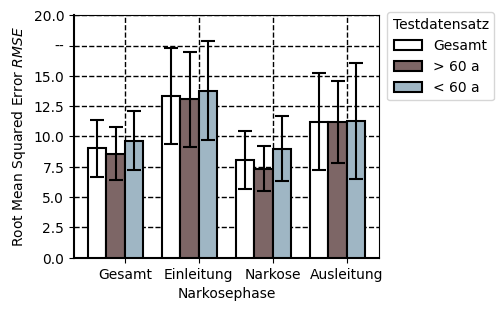

In [12]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec

### Plot

fig = plt.figure(figsize=(10/2.54, 8/2.54))
label = ['Gesamt','> 60 a', '< 60 a']
x_label = ['Gesamt','Einleitung', 'Narkose', 'Ausleitung']

x = np.arange(len(x_label))  # the label locations
width = 0.25  # the width of the bars
multiplier = -1.5

color1 = (0, 0, 0)
color2 = (1, 1, 1)
color3 = (159/255, 182/255, 196/255)
color4 = (125/255, 102/255, 102/255)
color5 = (153/255, 0, 0)

colors =  [color2, color4, color3]
report = [all_rep, old_rep, young_rep]
report_std = [all_rep_std, old_rep_std, young_rep_std]


for rep, rep_std, color, lab in zip(report, report_std, colors, label):
    offset = width * multiplier
    rects = plt.bar(x + offset, list(rep["Prediction RMSE"]), width, label=lab, color=color, edgecolor='black', linewidth=1.5, zorder=3)
    plt.errorbar(x + offset, list(rep["Prediction RMSE"]), yerr=list(rep_std["Prediction RMSE"]), fmt='none', ecolor='black', elinewidth=1.5, capsize=5, capthick=1.5, zorder=4)
    multiplier += 1

plt.legend(title='Testdatensatz', loc='upper right', ncol=1, bbox_to_anchor=(1.4, 1.04))

plt.ylabel('Root Mean Squared Error $RMSE$')
plt.xlabel('Narkosephase')
plt.grid(True, linestyle='--',color='k', linewidth=1, zorder=0)


# Axis settings
ax = plt.gca()
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

ax.set_ylim(bottom=0, top=20.0)

# Einheiten auf y-Achse
yunit = '--'
ticks = list(range(0, 210, 25))
ticks = [tick/10 for tick in ticks]
ticks_with_units = [yunit if i == len(ticks) - 2 else ticks[i] for i in range(len(ticks))]
ax.set_yticks(ticks)
ax.set_yticklabels(ticks_with_units)

ax.set_xticks(x)
ax.set_xticklabels(x_label)

plt.grid(axis='y', linewidth=1.0)

x = 3.9
#plt.text(x, 0, s='Modell: VProp', fontsize=10, fontweight='bold')

plt.savefig('age_rmse.pdf', bbox_inches='tight', pad_inches=0.2, format='pdf')
plt.show()

# Testing Gender

## Male

In [13]:
male_rep = phases_report(y_pred[m_index_test], bis.test_dataset[m_index_test], propofolrate.test_dataset[m_index_test])
male_rep

,Prediction MSE,Baseline MSE,Prediction MAE,Baseline MAE,Prediction RMSE,Baseline RMSE
All,72.75,122.47,6.51,6.94,8.53,11.07
Induction,174.45,600.22,10.78,17.60,13.21,24.50
Maintenance,58.87,53.44,5.93,5.27,7.67,7.31
Recovery,104.52,335.83,7.76,12.74,10.22,18.33


In [14]:
male_rep_std = phases_report_std(male_rep,y_pred[m_index_test], bis.test_dataset[m_index_test], propofolrate.test_dataset[m_index_test])
male_rep_std

All      	min: 	 9 	max: 	 15
Induction 	min: 	 17 	max: 	 6
Maintenance 	min: 	 8 	max: 	 10
Recovery 	min: 	 13 	max: 	 16


,Prediction MSE,Baseline MSE,Prediction MAE,Baseline MAE,Prediction RMSE,Baseline RMSE
All,26.73,64.46,1.35,1.66,1.58,2.78
Induction,98.97,399.51,3.24,8.34,3.48,7.32
Maintenance,26.01,31.24,1.49,1.50,1.75,2.00
Recovery,72.92,179.52,3.08,5.99,3.67,6.45


## Female

In [15]:
fem_rep = phases_report(y_pred[f_index_test], bis.test_dataset[f_index_test], propofolrate.test_dataset[f_index_test])
fem_rep

,Prediction MSE,Baseline MSE,Prediction MAE,Baseline MAE,Prediction RMSE,Baseline RMSE
All,115.31,208.12,8.44,9.94,10.74,14.43
Induction,186.70,750.27,10.57,20.57,13.66,27.39
Maintenance,91.49,93.06,7.64,7.47,9.56,9.65
Recovery,182.10,428.86,10.77,15.33,13.49,20.71


In [16]:
fem_rep_std = phases_report_std(fem_rep,y_pred[f_index_test], bis.test_dataset[f_index_test], propofolrate.test_dataset[f_index_test])
fem_rep_std

All      	min: 	 3 	max: 	 2
Induction 	min: 	 4 	max: 	 1
Maintenance 	min: 	 5 	max: 	 2
Recovery 	min: 	 3 	max: 	 5


,Prediction MSE,Baseline MSE,Prediction MAE,Baseline MAE,Prediction RMSE,Baseline RMSE
All,71.89,91.01,2.87,3.19,3.07,3.50
Induction,160.54,397.72,4.52,8.44,5.15,6.71
Maintenance,75.16,53.11,3.12,2.77,3.20,2.82
Recovery,84.00,186.30,3.43,6.45,3.14,6.04


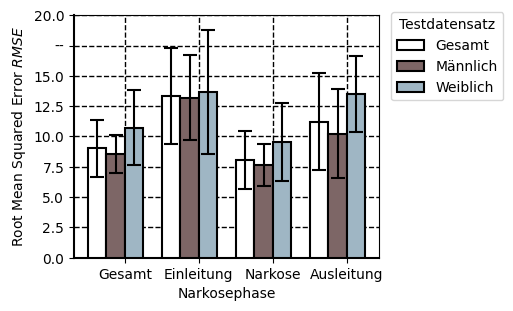

In [17]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec

### Plot

fig = plt.figure(figsize=(10/2.54, 8/2.54))
label = ['Gesamt','Männlich', 'Weiblich']
x_label = ['Gesamt','Einleitung', 'Narkose', 'Ausleitung']

x = np.arange(len(x_label))  # the label locations
width = 0.25  # the width of the bars
multiplier = -1.5

color1 = (0, 0, 0)
color2 = (1, 1, 1)
color3 = (159/255, 182/255, 196/255)
color4 = (125/255, 102/255, 102/255)
color5 = (153/255, 0, 0)

colors =  [color2, color4, color3]
report = [all_rep, male_rep, fem_rep]
report_std = [all_rep_std, male_rep_std, fem_rep_std]

for rep, rep_std, color, lab in zip(report, report_std, colors, label):
    offset = width * multiplier
    rects = plt.bar(x + offset, list(rep["Prediction RMSE"]), width, label=lab, color=color, edgecolor='black', linewidth=1.5, zorder=3)
    plt.errorbar(x + offset, list(rep["Prediction RMSE"]), yerr=list(rep_std["Prediction RMSE"]), fmt='none', ecolor='black', elinewidth=1.5, capsize=5, capthick=1.5, zorder=4)
    multiplier += 1

plt.legend(title='Testdatensatz', loc='upper right', ncol=1, bbox_to_anchor=(1.43, 1.04))

plt.ylabel('Root Mean Squared Error $RMSE$')
plt.xlabel('Narkosephase')
plt.grid(True, linestyle='--',color='k', linewidth=1, zorder=0)


# Axis settings
ax = plt.gca()
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

ax.set_ylim(bottom=0, top=20)

# Einheiten auf y-Achse
yunit = '--'
ticks = list(range(0, 210, 25))
ticks = [tick/10 for tick in ticks]
ticks_with_units = [yunit if i == len(ticks) - 2 else ticks[i] for i in range(len(ticks))]
ax.set_yticks(ticks)
ax.set_yticklabels(ticks_with_units)

ax.set_xticks(x)
ax.set_xticklabels(x_label)

plt.grid(axis='y', linewidth=1.0)

x = 3.9
#plt.text(x, 0, s='Modell: VProp', fontsize=10, fontweight='bold')

plt.savefig('gender_rmse.pdf', bbox_inches='tight', pad_inches=0.2, format='pdf')
plt.show()